<a href="https://colab.research.google.com/github/chrismartel/COMP551/blob/main/projects/p1/adult_salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project 1: Machine Learning 101

Christian Martel (260867191)

Luka Loignon (260871296)

Marie Guertin (260870552)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ~/.ssh/
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
!cat id_rsa.pub
# then, copy key to github account

/root/.ssh
Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): ^C
# github.com:22 SSH-2.0-babeld-a3fae306
ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDUvpRa6WgSDQVx3dff9alOb3YmE6ABu8XLxuIbDCEYixLrehUB490EycWAlfI2Tu8RwgjmJXkEMoiQ2wXw7jb0o0TlaCd8MEZjEu4/zgubDSpaVEM3HDvDW06tsOBLIxswP0Qz9vzhK1kH1s0v1vEPovuQnNu0YJXI696L0zmlZ36IcfQuPoKsLh1yxsnjKq28R5ylqt9TGPkT+WfWhTwkFwboyk0Mk/9hJBsNGtKHjUzw3BkolpmPwdgKk7G5RSIGLWUGdoFxAgHlfDCHzIbUCmWGI2PP7fs9eVWRP4VCZmYoItRVABnxUpSZvLE7HuB+QZYtHKQL8znej8ApfIuhCwy5XhoIdhryNDmrj8ZGSL/iPc+dwo9KB9HBta5AP06HAIQUMhakpTOZJNKW2c8w3M+4wNUfc7KapecrlPon7kJCdX45/DyZpqHMzwT9r38lpxyZGSOOMiNwiGhE+K/wWhCXlz7KKwIsPPpYL6rhfga4FqZs09kVTzVptiiqbVxPRCp2nSmCb8/1WbDoCFIamDS4HN2+UhIymbhlbENfbmAwrGdCto1xhMIeVFcEy4R6ScGwk4vQplwFBfl0xC9cpa0u5li3V04uZglV0vi0V4WngrPPwl7PfyCocAxHK/nglT3f7fCmTA5e+U0geb1g5ZX13pCCto328FQLxCEndw== root@b6e127dff251


In [ ]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts


# github.com:22 SSH-2.0-babeld-a3fae306


In [2]:
%cd /content/drive/MyDrive/git/COMP551/projects/p1

/content/drive/MyDrive/git/COMP551/projects/p1


# PART I: Adult Dataset

Prediction task is to determine whether someone makes over 50K a year.
https://archive.ics.uci.edu/ml/datasets/Adult

## Imports and Setup

In [64]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

# other py files
import my_validation
import my_preprocessing

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(1234)

## Data Preprocessing

### 1. Import Data

In [65]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
train_df = pd.read_csv("data/adult.data", usecols = range(15), names = columns)
test_df = pd.read_csv("data/adult.test", usecols = range(15), names = columns)
display(train_df)
display(test_df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


### Check all unique values per feature

It is observed that age in the test dataset is in string format. It should be convert to int format.

It is observed that unknown values are represented by '?'. These values should be impute.

It is observed that labels in 'salary' column from test dataframe have a dot at the end

In [66]:
# print unique values for each column
print("TEST DATASET")
for c in test_df.columns:
    print("{c}: ".format(c=c), test_df[c].unique())
    
print("\nTRAIN DATASET")
for c in train_df.columns:
    print("{c}: ".format(c=c), train_df[c].unique())

TEST DATASET
age:  ['|1x3 Cross validator' '25' '38' '28' '44' '18' '34' '29' '63' '24' '55'
 '65' '36' '26' '58' '48' '43' '20' '37' '40' '72' '45' '22' '23' '54'
 '32' '46' '56' '17' '39' '52' '21' '42' '33' '30' '47' '41' '19' '69'
 '50' '31' '59' '49' '51' '27' '57' '61' '64' '79' '73' '53' '77' '80'
 '62' '35' '68' '66' '75' '60' '67' '71' '70' '90' '81' '74' '78' '82'
 '83' '85' '76' '84' '89' '88' '87']
workclass:  [nan ' Private' ' Local-gov' ' ?' ' Self-emp-not-inc' ' Federal-gov'
 ' State-gov' ' Self-emp-inc' ' Without-pay' ' Never-worked']
fnlwgt:  [    nan 226802.  89814. ... 349230. 321403.  83891.]
education:  [nan ' 11th' ' HS-grad' ' Assoc-acdm' ' Some-college' ' 10th'
 ' Prof-school' ' 7th-8th' ' Bachelors' ' Masters' ' Doctorate' ' 5th-6th'
 ' Assoc-voc' ' 9th' ' 12th' ' 1st-4th' ' Preschool']
education-num:  [nan  7.  9. 12. 10.  6. 15.  4. 13. 14. 16.  3. 11.  5.  8.  2.  1.]
marital-status:  [nan ' Never-married' ' Married-civ-spouse' ' Widowed' ' Divorced'
 ' Sepa

### 2. Clean up Data

1. Categorical data is not stripped, labels contain left white spaces.

2. First row of test data set is junk data

3. AEnsure train set and test set have same dtypes for each column

4. Remove dot from test dataset salary labels



In [67]:
# 1.
train_df = my_preprocessing.strip_labels(train_df)
test_df = my_preprocessing.strip_labels(test_df)

# 2.
test_df.drop(labels=0, inplace = True)

# 3. Ensure Train and test dataset have same data types
for c in train_df.columns:
  test_df[c] = test_df[c].astype(train_df[c].dtype, errors='ignore')

#4.
test_df['salary'] = test_df['salary'].apply(lambda label: label[:-1])

# merge test and train df for rest of preprocesing
merged_df = pd.concat([train_df, test_df], axis = 0)
display(merged_df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16278,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16279,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16280,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


### 3. Remove Useless Columns

From the imported datasets, we observe that the education-num column is the same as the education column. This column is not an important feature so it will be removed.

In [68]:
# remove columns with too much missing data
merged_df.drop(columns = 'education-num', inplace = True)

### 4. Data Imputation

For continuous data: replace Nan values or invalid values with mean value of column

For categorical data: replace Nan values or invalid values with most occurring features

In [69]:
# map the invalid entries for each column
invalid_entries_dict = {
    'age':[],
    'workclass':['?'],
    'fnlwgt':[],
    'education':[],
    'marital-status':[],
    'occupation':['?'],
    'relationship':[],
    'race':[],
    'sex':[],
    'hours-per-week':[],
    'native-country':['?']
}
merged_df = my_preprocessing.imputation(merged_df, invalid_entries_dict)

### 6. Categorical Features One-Hot-Encoding 

In [70]:
x_merged_df = merged_df.iloc[:,:-1]
y_merged_df = merged_df.iloc[:,-1]
# one-hot-encode categorical features
x_merged_df = my_preprocessing.ohe(x_merged_df)
display(x_merged_df)

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,2174,0,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,83311,0,0,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,215646,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,234721,0,0,40,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,338409,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,215419,0,0,36,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### 7. Normalize Column Data

Apply min-max normalization. Normalization is important for KNN since distance is a major factor in predictions.

In [71]:
x_merged_df =(x_merged_df-x_merged_df.min())/(x_merged_df.max()-x_merged_df.min())

# Remove NaN values generated form merging both sets
x_merged_df.fillna(value = 0, inplace = True)
display(x_merged_df)

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.301370,0.044131,0.021740,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.048052,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.137581,0.000000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.150486,0.000000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### 8. Feature Importance for Gradient Boosting

{'age': 117,
 'capital-gain': 97,
 'capital-loss': 73,
 'education_10th': 8,
 'education_11th': 8,
 'education_5th-6th': 5,
 'education_7th-8th': 10,
 'education_9th': 7,
 'education_Assoc-voc': 3,
 'education_Bachelors': 18,
 'education_Doctorate': 11,
 'education_HS-grad': 12,
 'education_Masters': 15,
 'education_Prof-school': 18,
 'fnlwgt': 41,
 'hours-per-week': 61,
 'marital-status_Married-AF-spouse': 2,
 'marital-status_Married-civ-spouse': 45,
 'marital-status_Never-married': 3,
 'marital-status_Widowed': 4,
 'native-country_Mexico': 6,
 'occupation_Exec-managerial': 13,
 'occupation_Farming-fishing': 9,
 'occupation_Handlers-cleaners': 5,
 'occupation_Machine-op-inspct': 5,
 'occupation_Other-service': 10,
 'occupation_Prof-specialty': 6,
 'occupation_Protective-serv': 1,
 'occupation_Sales': 6,
 'occupation_Tech-support': 3,
 'occupation_Transport-moving': 1,
 'race_Asian-Pac-Islander': 1,
 'race_Black': 3,
 'race_White': 3,
 'relationship_Not-in-family': 2,
 'relationship_Ot

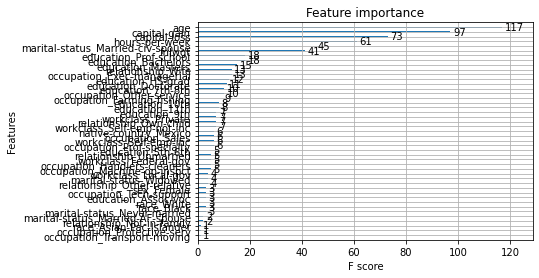

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,176.301370,9.046898,10.544005,0.0,121.377551,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,264.452055,9.850607,0.000000,0.0,37.346939,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,168.287671,28.204169,0.000000,0.0,121.377551,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,288.493151,30.849684,0.000000,0.0,121.377551,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [72]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model no training data
model = XGBClassifier()
best_score_tmp = model.fit(x_merged_df, y_merged_df)

display(best_score_tmp.get_booster().get_fscore())
tmp = best_score_tmp.get_booster().get_fscore()

# plot feature importance
best_score = plot_importance(model)
plt.show()

for key,value in tmp.items():
  x_merged_df[key]=x_merged_df[key] * 5*value

display(x_merged_df)

### 5. Split Train Test Sets

In [73]:
# unmerge back to train and test sets
x_train_df, y_train_df = x_merged_df.iloc[:train_df.shape[0],:], y_merged_df.iloc[:train_df.shape[0]]
x_test_df, y_test_df = x_merged_df.iloc[train_df.shape[0]:,:], y_merged_df.iloc[train_df.shape[0]:]

display(x_train_df)
display(x_test_df)

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,176.301370,9.046898,10.544005,0.0,121.377551,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,264.452055,9.850607,0.000000,0.0,37.346939,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,168.287671,28.204169,0.000000,0.0,121.377551,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,288.493151,30.849684,0.000000,0.0,121.377551,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
1,64.109589,29.751396,0.000000,0.0,121.377551,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,168.287671,10.752509,0.000000,0.0,152.500000,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,88.150685,45.027978,0.000000,0.0,121.377551,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,216.369863,20.531413,37.287173,0.0,121.377551,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### 9. Convert to Numpy

In [75]:
# random permutations of indices
inds = np.random.permutation(range(x_train_df.shape[0]))

# split into features set and prediction set
x_train, y_train = x_train_df.to_numpy()[inds,:], y_train_df.to_numpy()[inds]
x_test, y_test = x_test_df.to_numpy(), y_test_df.to_numpy()

## Experiments

### 1. KNN

In [76]:
from sklearn.neighbors import KNeighborsClassifier

# number of folds for L-fold cross-validation
L = 5

# range of number of nearest neighbors (K)
K_list = range(1,31) # [1,2,...,30]

#### Cross-Validation

In [ ]:
# knn cross-validation on full dataset
err_val_matrix, err_train_matrix = my_validation.knn_cross_validation(x_train, y_train, K_list, L, my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis=1)

# Visualize
plt.title('Error Rate of KNN for Different K Values with Full Dataset')
plt.plot(K_list, np.mean(err_train_matrix, axis=1),  label='train')
plt.errorbar(K_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Error Rate')
plt.ylim(0,0.5)
plt.show()

# The best K parameter is the one providing the smallest error rate
best_k = K_list[np.argmin(err_val_means)]
print("Best K parameter: {k}".format(k=best_k))

KeyboardInterrupt: ignored

#### Sample Growing Data

Observe the effect of growing the sample size on the training and validation errors.

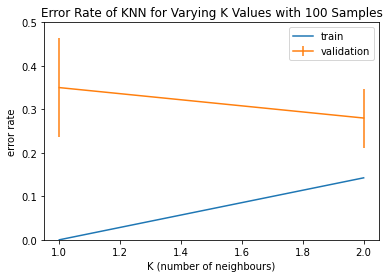

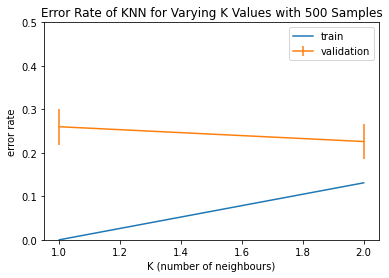

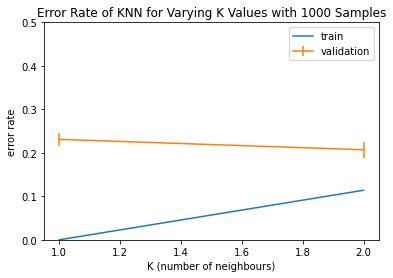

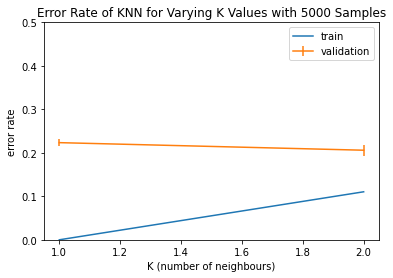

In [ ]:
sizes = [100, 500, 1000, 5000]

for s in sizes:
    # select s random samples from train dataset
    x_subset, y_subset = x_train[inds[:s]], y_train[inds[:s]]
    
    # apply cross validation to get validation and train accuracy matrices 
    err_val_matrix, err_train_matrix = my_validation.knn_cross_validation(x_subset, y_subset, K_list, L, my_validation.error_rate)
    
    err_val_means = np.mean(err_val_matrix, axis=1)
    
    plt.title('Error Rate of KNN for Varying K Values with {size} Samples'.format(size = s))
    plt.plot(K_list, np.mean(err_train_matrix, axis=1),  label='train')
    plt.errorbar(K_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('error rate')
    plt.ylim(0,0.5)
    plt.show()

#### Use Best K Parameter on Test Set

In [ ]:
model = KNeighborsClassifier(n_neighbors=best_k)
start_time = time.time()
model.fit(x_train, y_train)
tr_end = time.time()
tr_time = tr_end - start_time

y_pred = model.predict(x_test)
pr_end = time.time()
pred_time = pr_end - tr_end

err_rate = my_validation.error_rate(y_test, y_pred)

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))

### 2. DECISION-TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Maximum tree depth hyper-parameter
max_depth_list = list(range(1,31)) #1-30

# Minimum samples per leaf parameter
min_samples_per_leaf_list = list(range(1, 301, 5)) #1-300


### For Maximum Depth Parameter

#### Cross-Validation

In [ ]:
# decision tree cross-validation on full dataset
err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_train, y_train, max_depth_list=max_depth_list, L=L, validation_metric_fn=my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis=1)

# Visualize
plt.title('Error Rate of Decision Tree for Different Maximum Depth Values with Full Dataset')
plt.plot(max_depth_list, np.mean(err_train_matrix, axis=1),  label='train')
plt.errorbar(max_depth_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('Maximum Depth')
plt.ylabel('Error Rate')
plt.ylim(0,0.5)
plt.show()

# The best K parameter is the one providing the smallest error rate
best_max_depth = max_depth_list[np.argmin(err_val_means)]
print("Best max depth parameter: {k}".format(k=best_max_depth))

#### Sample Growing Data

Observe the effect of growing the sample size on the training and validation errors.

In [ ]:
sizes = [100, 500, 1000, 5000]

for s in sizes:
    # select s random samples from train dataset
    x_subset, y_subset = x_train[inds[:s]], y_train[inds[:s]]
    
    # apply cross validation to get validation and train accuracy matrices 
    err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_subset, y_subset, max_depth_list=max_depth_list, L=L, validation_metric_fn=my_validation.error_rate)
    
    err_val_means = np.mean(err_val_matrix, axis=1)
    
    plt.title('Error Rate of Decision Tree for Varying Max Depth Values with {size} Samples'.format(size = s))
    plt.plot(max_depth_list, np.mean(err_train_matrix, axis=1),  label='train')
    plt.errorbar(max_depth_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('Max Depth')
    plt.ylabel('error rate')
    plt.ylim(0,0.5)
    plt.show()

#### Use Best Max Depth Parameter on Test Set

In [ ]:
model = DecisionTreeClassifier(max_depth=best_max_depth)
start_time = time.time()
model.fit(x_train, y_train)
tr_end = time.time()
tr_time = tr_end - start_time

y_pred = model.predict(x_test)
pr_end = time.time()
pred_time = pr_end - tr_end

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))

### For Minimum Samples per Leaf Parameter

#### Cross-Validation

Vary the minimum samples per leaf, with a constant None max depth.

In [ ]:
# decision tree cross-validation on full dataset
err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_train, y_train, min_samples_per_leaf_list=min_samples_per_leaf_list, L=L, validation_metric_fn=my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis=1)

# Visualize
plt.title('Error Rate of Decision Tree for Different Minimum Samples per Leaf Values with Full Dataset')
plt.plot(min_samples_per_leaf_list, np.mean(err_train_matrix, axis=1),  label='train')
plt.errorbar(min_samples_per_leaf_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('Minimum Samples per Leaf')
plt.ylabel('Error Rate')
plt.ylim(0,0.5)
plt.show()

best_min_samples = min_samples_per_leaf_list[np.argmin(err_val_means)]
print("Best min samples per leaf parameter: {k}".format(k=best_min_samples))

#### Sample Growing Data

Observe the effect of growing the sample size on the training and validation errors.

In [ ]:
sizes = [100, 500, 1000, 5000]

for s in sizes:
    # select s random samples from train dataset
    x_subset, y_subset = x_train[inds[:s]], y_train[inds[:s]]
    
    # apply cross validation to get validation and train accuracy matrices 
    err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_subset, y_subset, min_samples_per_leaf_list=min_samples_per_leaf_list, L=L, validation_metric_fn=my_validation.error_rate)
    
    err_val_means = np.mean(err_val_matrix, axis=1)
    
    plt.title('Error Rate of Decision Tree for Varying Minimum Samples per Leaf Values with {size} Samples'.format(size = s))
    plt.plot(min_samples_per_leaf_list, np.mean(err_train_matrix, axis=1),  label='train')
    plt.errorbar(min_samples_per_leaf_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('Minium Samples per Leaf')
    plt.ylabel('Error Rate')
    plt.ylim(0,0.5)
    plt.show()

#### Use Best Min Sampled per Leaf Parameter on Test Set

In [ ]:
model = DecisionTreeClassifier(min_samples_leaf=best_min_samples)
start_time = time.time()
model.fit(x_train, y_train)
tr_end = time.time()
tr_time = tr_end - start_time

y_pred = model.predict(x_test)
pr_end = time.time()
pred_time = pr_end - tr_end

err_rate = my_validation.error_rate(y_test, y_pred)

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))

### Grid Search
#### Max Depth and Min Samples per Leaf Combined

#### Cross-Validation

In [ ]:
# Temporary lits to compute quickly
max_depth_list = list(range(1,31)) #1-30
min_samples_per_leaf_list = list(range(1,301,10)) #1-100

err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_train, y_train,max_depth_list=max_depth_list, min_samples_per_leaf_list=min_samples_per_leaf_list, L=L, validation_metric_fn=my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis = -1)
err_train_means = np.mean(err_train_matrix, axis = -1)

err_val_min_params = np.where(err_val_means == np.amin(err_val_means))
display(err_val_min_params)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
xdata = list()
for md in max_depth_list:
  for i in range(len(min_samples_per_leaf_list)):
    xdata.append(md)

ydata = len(max_depth_list) * min_samples_per_leaf_list

zdata_val, zdata_train = err_val_means.flatten(), err_train_means.flatten()

# The best parameter is the one providing the smallest error rate
best_max_depth_combine = max_depth_list[err_val_min_params[0][0]]
print("Best max depth parameter: {k}".format(k=best_max_depth_combine))
best_min_samples_combine = min_samples_per_leaf_list[err_val_min_params[1][0]]
print("Best min samples per leaf parameter: {k}".format(k=best_min_samples_combine))

# Visualization
ax.scatter3D(xdata, ydata, err_val_means, label='validation', color='blue')

ax.scatter3D(xdata,ydata, err_train_means, label='train', color='red')

ax.set_title('Error Rate of Decision Tree for Different Max Depth and Minimum Samples per Leaf Values with Full Dataset')
ax.legend()
ax.set_xlabel('Maximum Depth')
ax.set_ylabel('Minimum Samples per Leaf')
ax.set_zlabel('Error Rate')
plt.show()

#### Use Best Parameter Combination on Test Set

In [ ]:
model = DecisionTreeClassifier(max_depth=best_max_depth_combine, min_samples_leaf=best_min_samples_combine)
start_time = time.time()
model.fit(x_train, y_train)
tr_end = time.time()
tr_time = tr_end - start_time

y_pred = model.predict(x_test)
pr_end = time.time()
pred_time = pr_end - tr_end

err_rate = my_validation.error_rate(y_test, y_pred)

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))